In [2]:
from sklearnex import patch_sklearn # intel device sklearn boosting
patch_sklearn()
import util
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torch.cuda import is_available
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # it take too much time to evaluation
from sklearn.svm import LinearSVC # if training dataset is too large, we will not train in default SVC
from sklearn.svm import SVC # only train in small training dataset
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from pycontractions import Contractions
from nltk.corpus import stopwords
import time
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna.visualization import plot_param_importances
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
from optuna.visualization import plot_optimization_history

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
dataset = pd.read_csv('./dataset/clear_lemmatize_expand_texts.csv')
dataset['text'] = dataset['text'].astype(str)

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if is_available() else 'cpu')
model.device

In [48]:
dataset['len'] = dataset['text'].apply(lambda x: len(x))
index = dataset[dataset['len'] == dataset['len'].max()].index[0]

In [53]:
def inference_test(cls, x=dataset['text'][index], times=10000, encoder=model):
    print(cls.__class__.__name__, encoder.__class__.__name__)
    a = []
    for _ in range(times):
        t1 = time.time()
        cls.predict([encoder.encode(x)])
        a.append(time.time() - t1)
    print(np.mean(a))
    return np.mean(a)

In [15]:
embedding = model.encode(dataset['text'], show_progress_bar=True, batch_size=512)
np.save('./dataset/clear_lemmatize_expand_texts_embedding.npy', embedding)

Batches: 100%|██████████| 3125/3125 [14:07<00:00,  3.69it/s] 


In [27]:
embedding = np.load(r'.\dataset\clear_lemmatize_expand_texts_embedding.npy')

In [28]:
X, Y = embedding, dataset['target'].to_numpy() // 4

In [29]:
def train(model: BaseEstimator, x=X, y=Y, batch=None, test_ratio=0.2, verbose=False):
    if verbose:
        print(model.__class__.__name__)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio)
    t1 = time.time()
    model.fit(x_train[:batch], y_train[:batch])
    t2 = time.time()
    train_sc = model.score(x_train[:batch], y_train[:batch])
    test_sc = model.score(x_test[:batch], y_test[:batch])
    if verbose:
        print('training time:', t2 - t1)
        print('train acc:', train_sc)
        print('test acc:', test_sc)
        print('eval time:', time.time() - t2)
    return train_sc, test_sc

In [57]:
def test_ratio(model, ratio_ragne=np.arange(0.991, 0.999, 0.001)):
    a = []
    for r in ratio_ragne:
        a.append(train(model=model, test_ratio=r))

    axes = plt.subplot()

    a = np.array(a)

    axes.set_xlabel('test ratio')
    axes.set_ylabel('acc')
    axes.set_title(model.__class__.__name__)

    sns.lineplot(x=ratio_ragne, y=a[:, 0], label='train_acc', ax=axes)
    sns.lineplot(x=ratio_ragne, y=a[:, 1], label='test_acc', ax=axes)
    plt.tight_layout()
    plt.show()
    return a

In [41]:
rfc = RandomForestClassifier(random_state=2024)
train(rfc, verbose=True, test_ratio=0.991)

RandomForestClassifier
training time: 0.9209997653961182
train acc: 0.9989583333333333
test acc: 0.7340848890010091
eval time: 6.432000398635864


(0.9989583333333333, 0.7340848890010091)

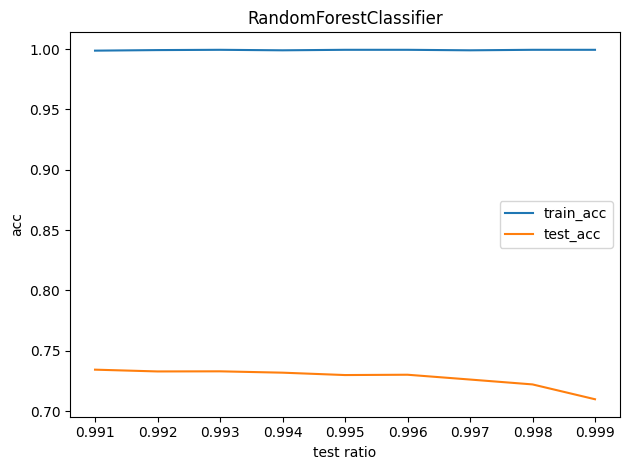

In [41]:
test_ratio(rfc)

In [42]:
xgb = XGBClassifier(random_state=2024)
train(xgb, verbose=True, test_ratio=0.991)

XGBClassifier
training time: 3.5587353706359863
train acc: 0.9984722222222222
test acc: 0.7381224772956609
eval time: 1.193023920059204


(0.9984722222222222, 0.7381224772956609)

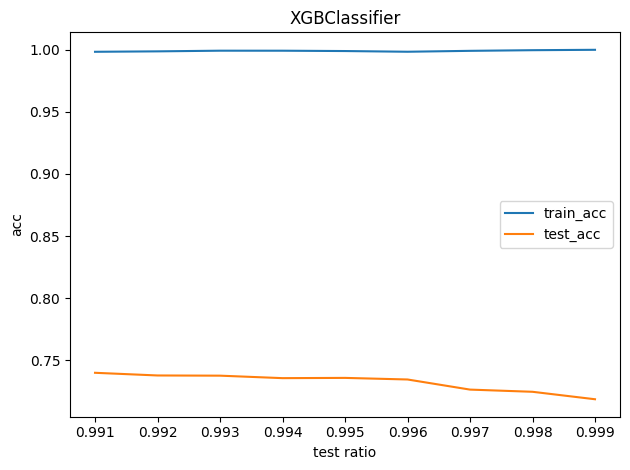

In [47]:
test_ratio(xgb)

In [43]:
dtc = DecisionTreeClassifier(random_state=2024)
train(dtc, verbose=True, test_ratio=0.991)

DecisionTreeClassifier
training time: 8.511064291000366
train acc: 0.9986111111111111
test acc: 0.6039820887991927
eval time: 0.8330597877502441


(0.9986111111111111, 0.6039820887991927)

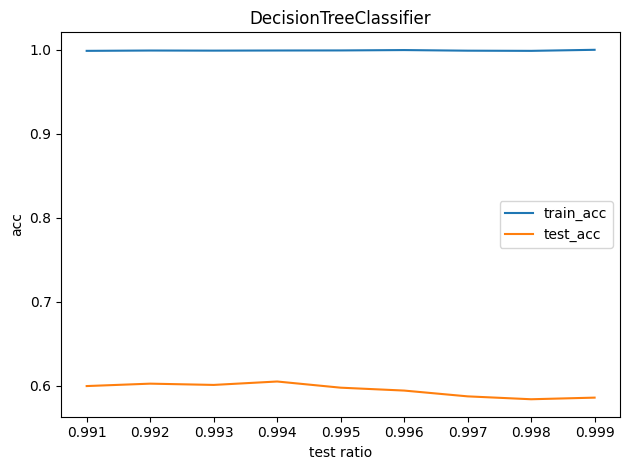

In [49]:
test_ratio(dtc)

In [44]:
lr = LogisticRegression(random_state=2024)
train(lr, verbose=True, test_ratio=0.991)

LogisticRegression
training time: 0.2116858959197998
train acc: 0.7809027777777777
test acc: 0.7667097628657922
eval time: 0.29931020736694336


(0.7809027777777777, 0.7667097628657922)

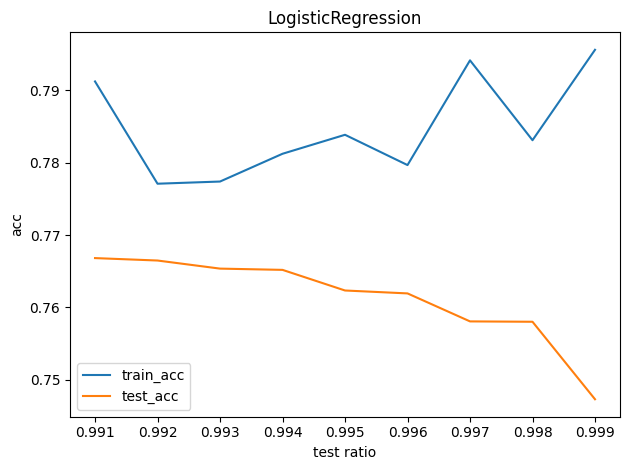

In [51]:
test_ratio(lr)

In [46]:
svc = SVC(random_state=2024)
train(svc, verbose=True, test_ratio=0.991)

SVC
training time: 0.8040015697479248
train acc: 0.908125
test acc: 0.7774394550958628
eval time: 26.899097681045532


(0.908125, 0.7774394550958628)

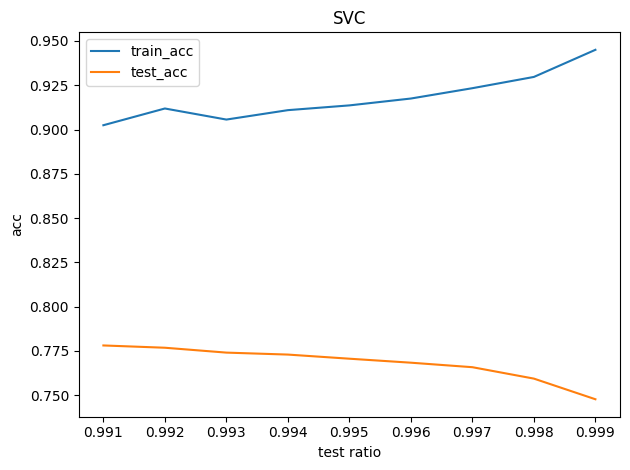

In [56]:
test_ratio(svc)

In [47]:
extree = ExtraTreesClassifier(random_state=2024)
train(extree, verbose=True, test_ratio=0.991)

ExtraTreesClassifier
training time: 0.6750466823577881
train acc: 0.9988888888888889
test acc: 0.7266839051463169
eval time: 5.27486777305603


(0.9988888888888889, 0.7266839051463169)

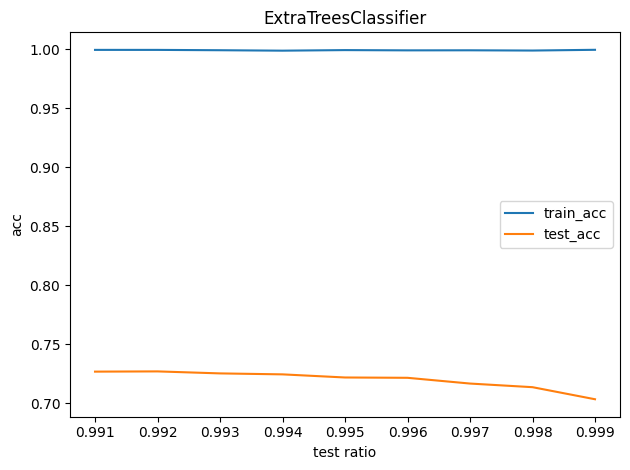

In [ ]:
test_ratio(extree)

#### inference test

In [54]:
inference_test(rfc)
inference_test(xgb)
inference_test(dtc)
inference_test(lr)
inference_test(svc)
inference_test(extree)

LinearSVC SentenceTransformer
0.008146489024162292
RandomForestClassifier SentenceTransformer
0.008942242145538331
XGBClassifier SentenceTransformer
0.012190344858169555
DecisionTreeClassifier SentenceTransformer
0.007905494737625121
LogisticRegression SentenceTransformer
0.008264973139762878
GaussianNB SentenceTransformer
0.006958610081672668
SVC SentenceTransformer
0.019476478958129883
ExtraTreesClassifier SentenceTransformer
0.009934049844741822


0.009934049844741822

#### optimize

In [205]:
def objective(trial: optuna.trial.Trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 9, 13),
        "subsample": trial.suggest_float("subsample", 0.99, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 225, 275, step=5),
        'eta': trial.suggest_float("eta", 0.7, 0.703, log=True),
        'alpha': trial.suggest_float('alpha', 5.45e-7, 5.46e-7, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1e-7, log=True),
        'gamma': trial.suggest_float("gamma", 4.48e-7, 4.485e-7, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 6),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 0.9)
    }
    xgb_model = XGBClassifier(**params)
    return np.array(train(xgb_model, test_ratio=0.991)).mean()

In [ ]:
study = optuna.create_study(direction='maximize')

In [210]:
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

Best trial parameters: {'max_depth': 10, 'subsample': 0.9944429956664866, 'n_estimators': 250, 'eta': 0.0450936851981266, 'alpha': 0.0005827763748669013, 'lambda': 8.079327547505147e-08, 'gamma': 1.1347841203453763e-06, 'min_child_weight': 6, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8008542412503581}
Best score: 0.8791894761183989


In [ ]:
study.optimize(objective, n_trials=100, n_jobs=2)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

In [207]:
evaluator = MeanDecreaseImpurityImportanceEvaluator()
plot_param_importances(study, evaluator=evaluator)

In [208]:
plot_optimization_history(study)

In [36]:
xgb = XGBClassifier(**study.best_params)
train(xgb, verbose=True, test_ratio=0.991)

XGBClassifier
training time: 5.033065557479858
train acc: 0.99875
test acc: 0.737864530776993
eval time: 1.2347474098205566


(0.99875, 0.737864530776993)

In [212]:
import pickle
pickle.dump(study, open('xgb_study.pickle', 'wb'))

In [24]:
import pickle
study = pickle.load(open('xgb_study.pickle', 'rb'))

In [25]:
study.best_params

{'max_depth': 10,
 'subsample': 0.9944429956664866,
 'n_estimators': 250,
 'eta': 0.0450936851981266,
 'alpha': 0.0005827763748669013,
 'lambda': 8.079327547505147e-08,
 'gamma': 1.1347841203453763e-06,
 'min_child_weight': 6,
 'grow_policy': 'lossguide',
 'colsample_bytree': 0.8008542412503581}

In [27]:
def objective(trial: optuna.trial.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        "min_samples_split": trial.suggest_float("min_samples_split", 0.000001, 0.1),
        'min_samples_leaf': trial.suggest_float("min_samples_leaf", 0.000001, 0.1),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }
    rfc_model = RandomForestClassifier(**params)
    return np.array(train(rfc_model, test_ratio=0.991)).mean()

In [9]:
study = optuna.create_study(direction='maximize')

[I 2024-05-26 15:11:31,430] A new study created in memory with name: no-name-7cb8aa47-2e80-4fe8-ac21-ab1825d008ef


In [15]:
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

Best trial parameters: {'n_estimators': 150, 'max_depth': 48, 'min_samples_split': 0.0054977615395777335, 'min_samples_leaf': 0.0010035190213542712, 'criterion': 'gini'}
Best score: 0.8416678229061554


In [28]:
study.optimize(objective, n_trials=100)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2024-05-26 16:56:57,675] Trial 200 finished with value: 0.811865995347012 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.004342415022964678, 'min_samples_leaf': 0.0026127496856710253, 'criterion': 'entropy'}. Best is trial 179 with value: 0.8696483630451844.
[I 2024-05-26 16:57:42,916] Trial 201 finished with value: 0.8682181298351833 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.0015841370743238893, 'min_samples_leaf': 1.5632393853737725e-06, 'criterion': 'entropy'}. Best is trial 179 with value: 0.8696483630451844.
[I 2024-05-26 16:58:26,911] Trial 202 finished with value: 0.8635517925215832 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.0020007148245829646, 'min_samples_leaf': 0.00012011504728439348, 'criterion': 'entropy'}. Best is trial 179 with value: 0.8696483630451844.
[I 2024-05-26 16:59:02,500] Trial 203 finished with value: 0.8171631138580558 and parameters: {'n_estimators': 100,

Number of finished trials: 300
Best trial parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 0.00025356666026683707, 'min_samples_leaf': 0.0002289280013731268, 'criterion': 'entropy'}
Best score: 0.8696483630451844


In [31]:
evaluator = MeanDecreaseImpurityImportanceEvaluator()
plot_param_importances(study, evaluator=evaluator)

In [34]:
plot_optimization_history(study)

In [35]:
rfc = RandomForestClassifier(**study.best_params)
train(rfc, verbose=True, test_ratio=0.991)

RandomForestClassifier
training time: 24.523168802261353
train acc: 0.9990972222222222
test acc: 0.7390249747729566
eval time: 20.546581745147705


(0.9990972222222222, 0.7390249747729566)

In [36]:
import pickle
pickle.dump(study, open('rfc_study.pickle', 'wb'))

In [83]:
def objective(trial: optuna.trial.Trial):
    params = {
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, step=5),
        'max_depth': trial.suggest_int('max_depth', 500, 600),
        "min_samples_split": trial.suggest_float("min_samples_split", 0, 0.2),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 300, 600),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_bins': trial.suggest_int('max_bins', 250, 300),
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }
    etc_model = ExtraTreesClassifier(**params)
    return np.array(train(etc_model, test_ratio=0.991)).mean()

In [64]:
study = optuna.create_study(direction='maximize')

[I 2024-05-26 22:32:13,609] A new study created in memory with name: no-name-2fb752e3-d701-4803-a4ff-430a2d363089


In [87]:
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

Best trial parameters: {'ccp_alpha': 0.0002478288667819229, 'n_estimators': 175, 'max_depth': 559, 'min_samples_split': 0.11783786182405333, 'min_samples_leaf': 408, 'criterion': 'entropy', 'bootstrap': False, 'max_bins': 272, 'max_features': 'sqrt'}
Best score: 0.7478363605785402


In [84]:
study.optimize(objective, n_trials=100)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2024-05-26 23:46:26,979] Trial 300 finished with value: 0.6722950653100124 and parameters: {'ccp_alpha': 0.010086083510842307, 'n_estimators': 170, 'max_depth': 515, 'min_samples_split': 0.11065434780125864, 'min_samples_leaf': 428, 'criterion': 'entropy', 'bootstrap': False, 'max_bins': 251, 'max_features': 'sqrt'}. Best is trial 266 with value: 0.7478363605785402.
[I 2024-05-26 23:46:45,984] Trial 301 finished with value: 0.7446515865007288 and parameters: {'ccp_alpha': 0.00017782387995331152, 'n_estimators': 160, 'max_depth': 527, 'min_samples_split': 0.10604190380361564, 'min_samples_leaf': 438, 'criterion': 'entropy', 'bootstrap': False, 'max_bins': 251, 'max_features': 'sqrt'}. Best is trial 266 with value: 0.7478363605785402.
[I 2024-05-26 23:46:51,389] Trial 302 finished with value: 0.559011660500056 and parameters: {'ccp_alpha': 0.009119011722219676, 'n_estimators': 160, 'max_depth': 525, 'min_samples_split': 0.10532227108147459, 'min_samples_leaf': 416, 'criterion': 'entro

Number of finished trials: 400
Best trial parameters: {'ccp_alpha': 0.0002478288667819229, 'n_estimators': 175, 'max_depth': 559, 'min_samples_split': 0.11783786182405333, 'min_samples_leaf': 408, 'criterion': 'entropy', 'bootstrap': False, 'max_bins': 272, 'max_features': 'sqrt'}
Best score: 0.7478363605785402


In [85]:
evaluator = MeanDecreaseImpurityImportanceEvaluator()
plot_param_importances(study, evaluator=evaluator)

In [86]:
plot_optimization_history(study)

In [89]:
etc = ExtraTreesClassifier(**study.best_params)
np.array(train(etc, verbose=True, test_ratio=0.991)).mean()

ExtraTreesClassifier
training time: 2.361729145050049
train acc: 0.7414583333333333
test acc: 0.7293504036326942
eval time: 17.723459720611572


0.7354043684830138

In [88]:
etc = ExtraTreesClassifier()
np.array(train(etc, verbose=True, test_ratio=0.991)).mean()

ExtraTreesClassifier
training time: 0.4827249050140381
train acc: 0.9988888888888889
test acc: 0.7283154641775984
eval time: 5.176174163818359


0.8636021765332437